In [ ]:
from google.colab import drive
drive.mount('/content/drive')     
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/ml_data"
%cd /content/drive/MyDrive/ml_data

Mounted at /content/drive
/content/drive/MyDrive/ml_data


In [ ]:
import pandas as pd
import numpy as np
import nltk
import wordcloud
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Начало работы с данными

In [ ]:
def make_array_single_dimension(l):
    l2 = []

    for x in l:
        if type(x).__name__ == "list":
            l2 += make_array_single_dimension(x)
        else:
            l2.append(x)

    return l2
def preprocess_csv ():
  df = pd.read_csv('banki_example.csv')
  title = df['title'].str.split(';').to_list()
  rating = df['rating'].str.split(';').to_list()
  bank_name = df['bank_name'].str.split(';').to_list()
  date = df['date'].str.split(';').to_list()
  message = df['message'].str.split(';').to_list()
  
  title = pd.Series(make_array_single_dimension(title))
  rating = pd.Series(make_array_single_dimension(rating))
  bank_name = pd.Series(make_array_single_dimension(bank_name))
  date = pd.Series(make_array_single_dimension(date))
  message = pd.Series(make_array_single_dimension(message))

  # преобразовываем в один датасет
  col = ['title','rating','bank','date','message']
  df = pd.concat([title,rating,bank_name,date,message],axis=1,ignore_index=True)
  df.columns=col
  df = df.loc[df['rating'] != '0']
  df['rating'] = df['rating'].astype('int64')
  return df


In [ ]:
data = preprocess_csv()
data.head(5)

,title,rating,bank,date,message
0,Благодарность,5,Тинькофф Банк,07.05.2021,"Обращался в Тинькофф Банк для того, чтобы уточ..."
1,Обман и отсутсвие клиентоориентированности,1,Альфа-Банк,07.05.2021,Брал кредит в банке. Одобрили одну сумму на ко...
2,Звонок в службу поддержки,5,Тинькофф Банк,07.05.2021,"Позвонил в службу поддержки поздно вечером, оч..."
3,Благодарность,5,Русский Стандарт,07.05.2021,Здравствуйте. Ранее я уже написала отзыв о сот...
4,Самый лучший банк,5,Кредит Европа Банк,07.05.2021,Являюсь клиентом этого банка более 5лет и не р...


In [ ]:
def allWords_len(data):
  allWords = []
  for wordList in data:
      allWords += wordList
  return len(allWords)
ln = allWords_len(data['message'])
ln

355484

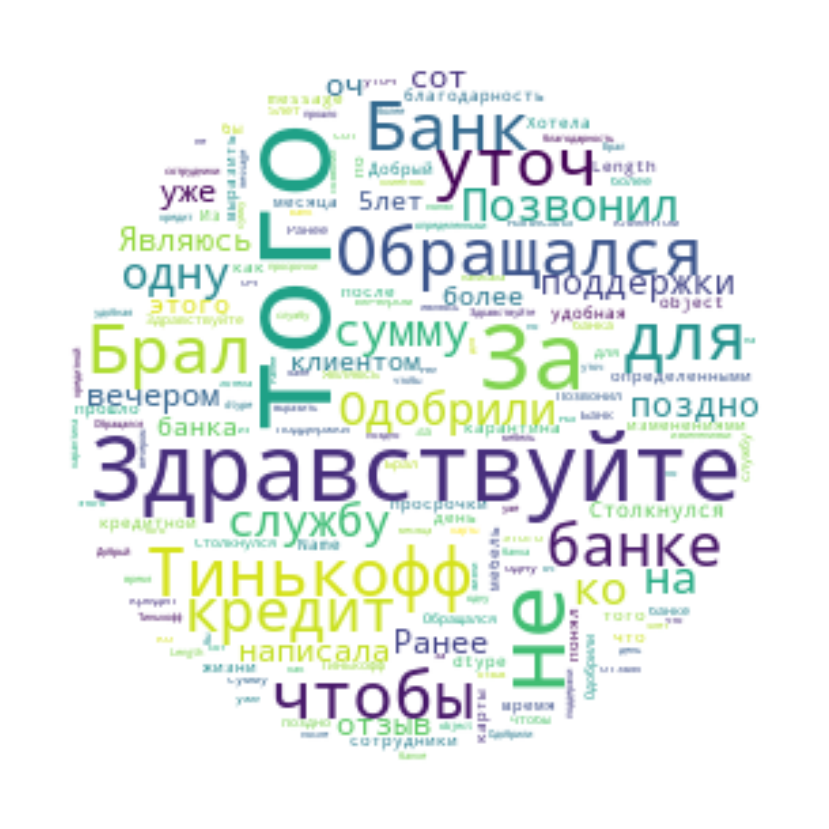

In [ ]:
def wordcloud (word): 
  x, y = np.ogrid[:300,:300]

  mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
  mask = 255 * mask.astype(int)


  wc = WordCloud(background_color="white", repeat=True, mask=mask,contour_color='steelblue')
  wc.generate(str(word))
  return wc
wc = wordcloud(data['message'])
fig = plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()


In [ ]:
from string import punctuation

punctuation = punctuation + '«' + '»' + '``' + '...' + '\xa0' + 'здравствуйте'
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»``...\xa0здравствуйте'

In [ ]:

def tokens_clean (tokens):
  tokens['tokens_clean']  = [nltk.word_tokenize(m.lower()) for m in tokens['message'].values]
  tokens['tokens_clean']  = [[ i for i in low if i not in punctuation]for low in tokens['tokens_clean'] ] 
  #выявляем только слова (без цифр)
  tokens['tokens_clean']  = [[token for token in tokens if token.isalpha()]for tokens in tokens['tokens_clean'] ]
  #stopwords 
  tokens['tokens_clean']  = [[words for words in stop if words not in stopwords]for stop in tokens['tokens_clean'] ]
# исключаем все английские слова (если начало слова русское то и слово целиком русское)
  r = re.compile("[а-яА-Я]+")
  tokens['tokens_clean']  = [[token for token in tokens if filter(r.match,token)]for tokens in tokens['tokens_clean'] ]
  return tokens

In [ ]:
data = tokens_clean(data)
ln = allWords_len(data['tokens_clean'])
print(ln)
data.head(5)

32160


,title,rating,bank,date,message,tokens_clean
0,Благодарность,5,Тинькофф Банк,07.05.2021,"Обращался в Тинькофф Банк для того, чтобы уточ...","[обращался, тинькофф, банк, уточнить, виртуаль..."
1,Обман и отсутсвие клиентоориентированности,1,Альфа-Банк,07.05.2021,Брал кредит в банке. Одобрили одну сумму на ко...,"[брал, кредит, банке, одобрили, одну, сумму, к..."
2,Звонок в службу поддержки,5,Тинькофф Банк,07.05.2021,"Позвонил в службу поддержки поздно вечером, оч...","[позвонил, службу, поддержки, поздно, вечером,..."
3,Благодарность,5,Русский Стандарт,07.05.2021,Здравствуйте. Ранее я уже написала отзыв о сот...,"[ранее, написала, отзыв, сотруднике, банка, ру..."
4,Самый лучший банк,5,Кредит Европа Банк,07.05.2021,Являюсь клиентом этого банка более 5лет и не р...,"[являюсь, клиентом, банка, разу, пожелела, апр..."


In [ ]:
for desc,tokens in zip(data['message'].head(5),data['tokens_clean'].head(5)):
  print('desc',desc)
  print ('tokens',tokens)

desc Обращался в Тинькофф Банк для того, чтобы уточнить, что за виртуальный счёт у меня в личном кабинете. Когда я заметил, что у меня высвечивается в личном кабинете "Тинькофф Мобайл" , я понял, что это что-то связано с теми сим-картами , которые я заказывал у Тинькофф. Но я никак не мог понять, что за счёт у меня в личном кабинете, если у меня по сути 2 сим-карты (заказывал их, примерно, пол года назад) а счёт один. Именно поэтому, я решил уточнить у специалистов. Ответил мне сперва специалист Данил, он переключил меня на специалиста Евгению, она мне объяснила всё подробно... Сказала , что это виртуальный счёт для всех сим-карт Тинькофф Мобайл и что я могу оплачивать покупки этим счётом, что очень удобно! Более того, обслуживание этой карты бесплатна, что обрадовала меня ещё больше! Хотелось бы, поблагодарить Тинькофф и в частности Евгению, за качественное обслуживание! Желаю Тинькофф дальнейшего процветания!
tokens ['обращался', 'тинькофф', 'банк', 'уточнить', 'виртуальный', 'счёт',

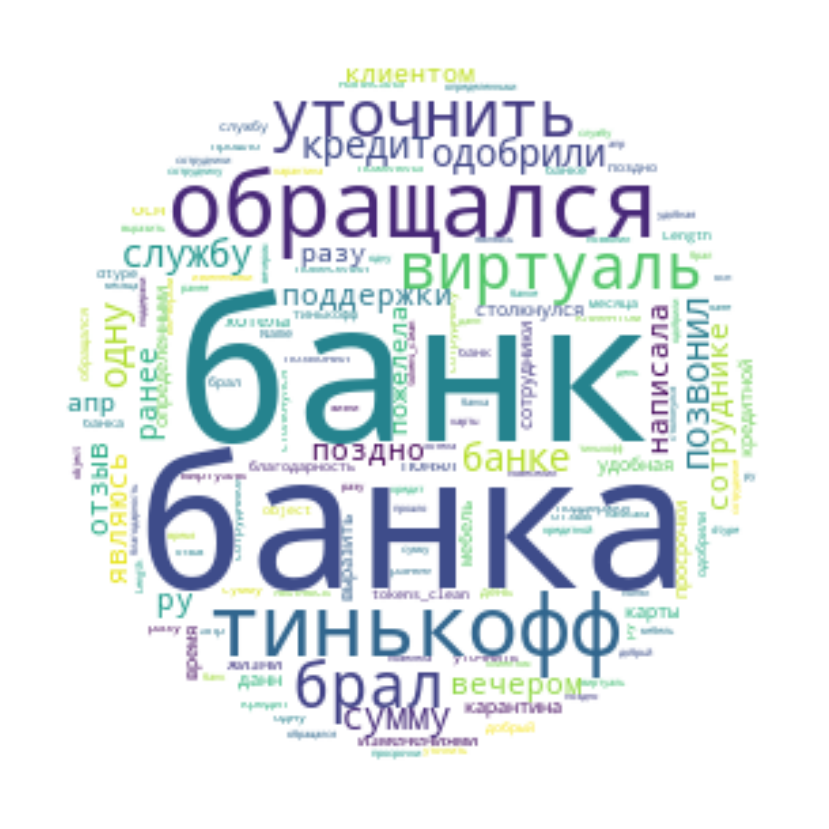

In [ ]:

wc = wordcloud(data['tokens_clean'])
fig = plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [ ]:
! pip install pymorphy2
from pymorphy2 import MorphAnalyzer
%timeit
morph = MorphAnalyzer()
data['tokens_clean'] = [[morph.normal_forms(token)[0] for token in tokens]for tokens in data['tokens_clean']]

[('банк', 1044), ('карта', 486), ('это', 298), ('день', 267), ('сотрудник', 248), ('который', 247), ('счёт', 240), ('клиент', 209), ('кредит', 204), ('деньга', 192), ('мой', 186), ('сумма', 179), ('вопрос', 175), ('год', 172), ('сказать', 156), ('свой', 148), ('отделение', 147), ('очень', 145), ('кредитный', 140), ('такой', 128), ('получить', 126), ('ответ', 120), ('платёж', 120), ('месяц', 118), ('мочь', 116), ('приложение', 115), ('договор', 111), ('условие', 108), ('время', 108), ('документ', 107)]


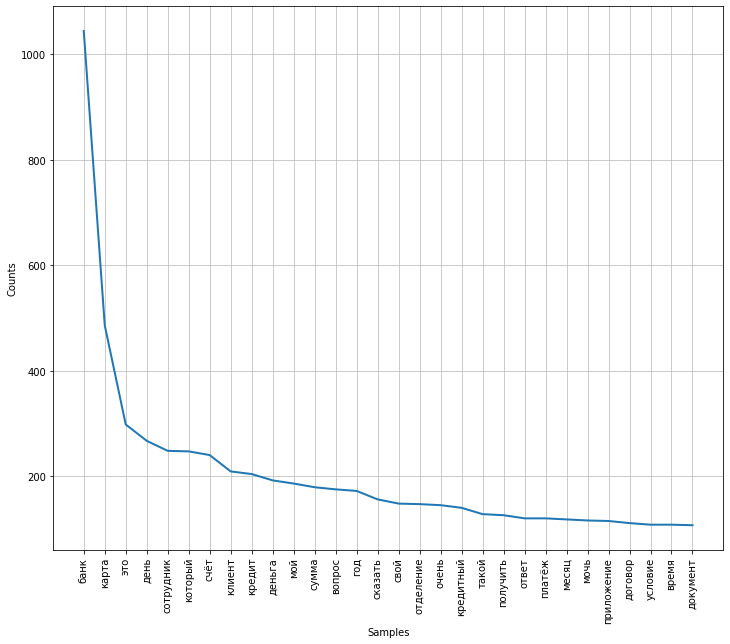

In [ ]:
from nltk.probability import FreqDist
allWords = []
for wordList in data['tokens_clean']:
    allWords += wordList
fdist = FreqDist(allWords)

print(fdist.most_common(30))
plt.figure(figsize=(12,10))
fdist.plot(30,cumulative=False)

plt.show()

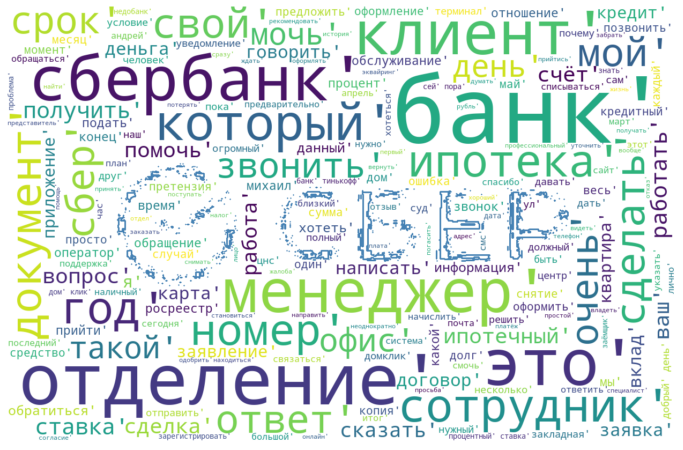

<Figure size 432x288 with 0 Axes>

In [ ]:
sber = data[data['bank']=='СберБанк']
sber_values = str([[word for word in words]for words in sber['tokens_clean'].values])
from PIL import Image
sber_mask = np.array(Image.open('sber.jpg'))
wc = WordCloud(background_color="white", mask=sber_mask,
                contour_width=3, contour_color='steelblue')
wc.generate(sber_values)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

In [ ]:
punctuation = punctuation + '«' + '»' + '``' + '...' + '\xa0' + 'здравствуйте' + 'это'
data['tokens_clean']  = [[ i for i in low if i not in punctuation]for low in data['tokens_clean'] ] 


In [ ]:
data['tokens_clean'].apply(lambda x: ' '.join(x))

0      обращаться тинькофф банк уточнить виртуальный ...
1      брать кредит банк одобрить один сумма который ...
2      позвонить служба поддержка поздно вечером очен...
3      ранее написать отзыв сотрудник банк русский ст...
4      являться клиент банк раз пожелела апрель месяц...
                             ...                        
395    столкнуться определённый изменение жизнь уйти ...
396    время карантин понять удобный мебель основопол...
397    просрочка кредитный карта сотрудник данный бан...
398    хотеть выразить благодарность сотрудник тинько...
399    добрый день пройти месяц банк повеселить измен...
Name: tokens_clean, Length: 384, dtype: object

In [ ]:
data['rating'] = np.where((data['rating'] >= 4), 1, 0)
data[:5]

,title,rating,bank,date,message,tokens_clean
0,Благодарность,1,Тинькофф Банк,07.05.2021,"Обращался в Тинькофф Банк для того, чтобы уточ...","[обращаться, тинькофф, банк, уточнить, виртуал..."
1,Обман и отсутсвие клиентоориентированности,0,Альфа-Банк,07.05.2021,Брал кредит в банке. Одобрили одну сумму на ко...,"[брать, кредит, банк, одобрить, один, сумма, к..."
2,Звонок в службу поддержки,1,Тинькофф Банк,07.05.2021,"Позвонил в службу поддержки поздно вечером, оч...","[позвонить, служба, поддержка, поздно, вечером..."
3,Благодарность,1,Русский Стандарт,07.05.2021,Здравствуйте. Ранее я уже написала отзыв о сот...,"[ранее, написать, отзыв, сотрудник, банк, русс..."
4,Самый лучший банк,1,Кредит Европа Банк,07.05.2021,Являюсь клиентом этого банка более 5лет и не р...,"[являться, клиент, банк, раз, пожелела, апрель..."


# Train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(data, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(data['tokens_clean'], 
                                                        data['rating'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(data)

Value counts for Train sentiments
0    166
1    102
Name: rating, dtype: int64
Value counts for Test sentiments
0    69
1    47
Name: rating, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                       tokens_clean
0    343  [добрый, время, сутки, угораздить, открыть, сч...
1    130  [связь, некорректно, отобразить, задолженность...
2    215  [установка, новый, приложение, росбанк, evo, н...
3    253  [заинтересовать, тема, инвестиция, приложение,...
4    376  [хотеть, выразить, огромный, благодарность, ка...


# ОБУЧЕНИЕ МОДЕЛИ WORD2VEC

word2vec преобразует каждое слово из корпуса в вектор высокой размерности. Модель позволяет правильно отразить контекст слов (находит слова которые близки друг другу)


In [ ]:

from gensim.models import Word2Vec
import time
# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

start_time = time.time()
tokens = pd.Series(data['tokens_clean']).values
# тренируем word2vec модель
w2v_model = Word2Vec(tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save('word2vec_model_file')

Time taken to train word2vec model: 3.1548962593078613


In [ ]:
w2v_model.wv.most_similar(positive=["кредит"])

[('страховка', 0.999958872795105),
 ('одобрить', 0.9999547600746155),
 ('ипотека', 0.9999546408653259),
 ('нужный', 0.9999529719352722),
 ('возможность', 0.9999526143074036),
 ('который', 0.9999520778656006),
 ('взять', 0.999951958656311),
 ('оформить', 0.9999517798423767),
 ('должный', 0.9999514818191528),
 ('оформление', 0.9999514222145081)]

In [ ]:
# Загрузите модель из файла модели
sg_w2v_model = Word2Vec.load('word2vec_model_file')

print('вектор одного слова равен: ',len(sg_w2v_model['связь']))

вектор одного слова равен:  1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


# Вычисление среднего значения по всем векторам слов в предложении

In [ ]:

# Store the vectors for train data in following file
word2vec_filename = '/content/drive/My Drive/ml_data' + '/train_rewiew.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['tokens_clean']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
x_train_rewiew = pd.read_csv('train_rewiew.csv')
x_train_rewiew

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.031040,-0.014082,-0.001178,-0.027896,0.005048,0.012749,0.005698,-0.006978,0.015291,0.042672,-0.022197,0.039366,0.031739,0.018597,-0.024951,-0.030206,0.032872,-0.018812,-0.038622,-0.005074,0.030227,-0.005600,0.032761,-0.068971,-0.008084,-0.018745,0.054241,0.023947,-0.031493,-0.040976,0.038482,0.048825,0.033832,0.081026,0.054793,-0.017723,-0.031578,0.026534,-0.020264,0.003241,...,-0.002681,-0.033337,0.032804,0.018721,-0.033763,-0.014142,0.000016,0.008124,0.026047,0.008171,-0.008204,-0.011454,-0.003049,0.007543,-0.045526,-0.037804,-0.038073,0.013137,0.006623,-0.029012,-0.003423,0.028231,0.023282,0.001329,-0.019031,-0.003479,-0.005877,-0.024939,0.035904,0.004082,-0.025067,0.065878,-0.027573,0.020322,0.038422,-0.010811,-0.045935,-0.045500,-0.060143,-0.007453
1,0.037010,-0.016864,-0.001363,-0.033199,0.006086,0.015306,0.006792,-0.008354,0.018208,0.050850,-0.026416,0.046994,0.037808,0.022353,-0.029924,-0.036155,0.039214,-0.022385,-0.046233,-0.005978,0.035883,-0.006722,0.039161,-0.082394,-0.009663,-0.022304,0.064699,0.028635,-0.037598,-0.049015,0.045989,0.058325,0.040328,0.096645,0.065385,-0.021151,-0.037799,0.031554,-0.024169,0.003829,...,-0.003320,-0.039710,0.039235,0.022484,-0.040220,-0.016888,0.000007,0.009704,0.031157,0.009730,-0.009735,-0.013643,-0.003556,0.008855,-0.054219,-0.045131,-0.045436,0.015540,0.008000,-0.034594,-0.004130,0.033681,0.027910,0.001438,-0.022753,-0.003993,-0.006986,-0.029724,0.042827,0.004777,-0.030007,0.078611,-0.032907,0.024203,0.045906,-0.012845,-0.054818,-0.054367,-0.071765,-0.008802
2,0.033310,-0.015166,-0.001225,-0.029866,0.005530,0.013889,0.006130,-0.007538,0.016482,0.045811,-0.023708,0.042356,0.033980,0.020040,-0.026859,-0.032567,0.035375,-0.020051,-0.041596,-0.005485,0.032303,-0.006050,0.035059,-0.074058,-0.008834,-0.020123,0.058218,0.025743,-0.033929,-0.043955,0.041364,0.052494,0.036389,0.086885,0.058765,-0.019074,-0.033984,0.028421,-0.021717,0.003421,...,-0.002988,-0.035740,0.035138,0.020080,-0.036279,-0.015254,0.000038,0.008704,0.027841,0.008706,-0.008924,-0.012303,-0.003241,0.008072,-0.048869,-0.040451,-0.040940,0.013945,0.007135,-0.031018,-0.003743,0.030201,0.024994,0.001353,-0.020280,-0.003704,-0.006443,-0.026822,0.038361,0.004397,-0.027080,0.070759,-0.029579,0.021750,0.041318,-0.011758,-0.049415,-0.048770,-0.064692,-0.007938
3,0.034761,-0.015719,-0.001420,-0.031140,0.005619,0.014116,0.006356,-0.007774,0.017160,0.047852,-0.024803,0.043934,0.035422,0.020852,-0.027938,-0.033867,0.036684,-0.021044,-0.043248,-0.005445,0.033686,-0.006279,0.036562,-0.077126,-0.008950,-0.020807,0.060640,0.026838,-0.035269,-0.045932,0.043046,0.054585,0.037775,0.090673,0.061228,-0.019857,-0.035533,0.029593,-0.022733,0.003608,...,-0.002916,-0.037271,0.036725,0.021170,-0.037717,-0.015806,-0.000071,0.009007,0.029244,0.009101,-0.009100,-0.012807,-0.003248,0.008333,-0.050794,-0.042306,-0.042720,0.014685,0.007537,-0.032374,-0.003858,0.031536,0.026143,0.001432,-0.021432,-0.003856,-0.006554,-0.027857,0.040179,0.004628,-0.028122,0.073537,-0.030801,0.022907,0.042931,-0.012148,-0.051529,-0.050897,-0.067391,-0.008401
4,0.036948,-0.016632,-0.001271,-0.033112,0.006008,0.015286,0.006666,-0.008248,0.018282,0.050732,-0.026407,0.046727,0.037565,0.022189,-0.029561,-0.035892,0.038897,-0.022375,-0.046023,-0.006233,0.035983,-0.006575,0.038737,-0.081907,-0.009387,-0.022410,0.064477,0.028522,-0.037418,-0.048755,0.045843,0.057953,0.040022,0.096015,0.064881,-0.021000,-0.037473,0.031451,-0.024171,0.003964,...,-0.003033,-0.039372,0.038984,0.022046,-0.040001,-0.016956,-0.000108,0.009761,0.031069,0.009584,-0.009883,-0.013646,-0.003788,0.008866,-0.054169,-0.044936,-0.045173,0.015560,0.007914,-0.034201,-0.003932,0.033592,0.027451,0.001612,-0.022548,-0.004097,-0.006878,-0.02973


# Обучение

Обучение модели выполнено с помощью Деревьев решении и XGBoost


## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_rewiew,Y_train['rating'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
test_features = []
for index,row in X_test.iterrows():
  model_vector = np.mean([sg_w2v_model[token] for token in row['tokens_clean']],axis=0).tolist()
  if type(model_vector) is list:
    test_features.append(model_vector)
  else:
    test_features.append(np.array([0 for i in range(1000)]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
 from sklearn.metrics import classification_report

 test_predict = clf.predict (test_features)
 print(classification_report(Y_test['rating'],test_predict))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66        69
           1       0.50      0.49      0.49        47

    accuracy                           0.59       116
   macro avg       0.58      0.58      0.58       116
weighted avg       0.59      0.59      0.59       116



## Xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score)
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':range(50,250,50)
}

gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1), 
 param_grid = param_test1, scoring=f1_scorer,n_jobs=-1, cv=5)
gsearch.fit(x_train_rewiew.values,Y_train['rating'])

#boost = xgb.XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=100,n_jobs=-1)
#boost.fit(x_train_rewiew.values,Y_train['rating'])

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2),
                         'n_estimators': range(50, 250, 50)},
 

In [ ]:
gsearch.best_estimator_,gsearch.best_params_,gsearch.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=7,
               min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
 {'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200},
 0.6489007724301842)

In [ ]:
boost = xgb.XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=200,min_child_weight= 3,n_jobs=-1)
boost.fit(x_train_rewiew.values,Y_train['rating'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
 test_predict = boost.predict (test_features)
 print(classification_report(Y_test['rating'],test_predict))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79        69
           1       0.70      0.66      0.68        47

    accuracy                           0.75       116
   macro avg       0.74      0.74      0.74       116
weighted avg       0.75      0.75      0.75       116

